**Task 1 – Machine Learning project**

*Welcome to Machine Learning. We are predicting airbnb prices in NewYork*

*This notebook contains all the sample code.*

# Setup

First, let's make sure this notebook works well in both python 2 and 3, import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures:

In [1]:
#imports
from __future__ import division, print_function, unicode_literals
import numpy as np
import seaborn as sns
import pandas as pd
import os
import tarfile
from six.moves import urllib
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings
from sklearn.model_selection import train_test_split
from pandas.plotting import scatter_matrix
import category_encoders as ce
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
import matplotlib.image as mpimg
from sklearn.preprocessing import StandardScaler




In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from xgboost.sklearn import XGBClassifier


In [3]:
# to make this notebook's output stable across runs
np.random.seed(42)

# Plot Configurations
%matplotlib inline

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "airbnb"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)

warnings.filterwarnings(action="ignore", message="^internal gelsd")

# Get the data

The data set was provided from Kaggle at this link (https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data).

In [4]:
AIR_BNB_PATH = os.path.join("datasets", "berlin-airbnb-open-data")

In [7]:
def load_air_bnb_data(air_bnb_path=AIR_BNB_PATH):
    csv_path = os.path.join(AIR_BNB_PATH, "listings.csv")
    return pd.read_csv(csv_path)

In [8]:
bnb = load_air_bnb_data()

# Explore the data

In [9]:
bnb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22552 entries, 0 to 22551
Data columns (total 16 columns):
id                                22552 non-null int64
name                              22493 non-null object
host_id                           22552 non-null int64
host_name                         22526 non-null object
neighbourhood_group               22552 non-null object
neighbourhood                     22552 non-null object
latitude                          22552 non-null float64
longitude                         22552 non-null float64
room_type                         22552 non-null object
price                             22552 non-null int64
minimum_nights                    22552 non-null int64
number_of_reviews                 22552 non-null int64
last_review                       18644 non-null object
reviews_per_month                 18638 non-null float64
calculated_host_listings_count    22552 non-null int64
availability_365                  22552 non-null int64

The features last_review and reviews_per_month have the same number of null values which implies that the only way reviews_per_month is null is if the property has never had a review. last_review is likely irrelevent but I belive reviews_per_month might be useful. I think it would make sense to replace null values with zero for reviews_per_month. 

In [10]:
bnb.isnull().sum()

id                                   0
name                                59
host_id                              0
host_name                           26
neighbourhood_group                  0
neighbourhood                        0
latitude                             0
longitude                            0
room_type                            0
price                                0
minimum_nights                       0
number_of_reviews                    0
last_review                       3908
reviews_per_month                 3914
calculated_host_listings_count       0
availability_365                     0
dtype: int64

In [11]:
bnb["room_type"].value_counts()

Private room       11534
Entire home/apt    10722
Shared room          296
Name: room_type, dtype: int64

In [12]:
bnb["neighbourhood_group"].value_counts()

Friedrichshain-Kreuzberg    5497
Mitte                       4631
Pankow                      3541
Neukölln                    3499
Charlottenburg-Wilm.        1592
Tempelhof - Schöneberg      1560
Lichtenberg                  688
Treptow - Köpenick           595
Steglitz - Zehlendorf        437
Reinickendorf                247
Marzahn - Hellersdorf        141
Spandau                      124
Name: neighbourhood_group, dtype: int64

In [13]:
bnb.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2015,Berlin-Mitte Value! Quiet courtyard/very central,2217,Ian,Mitte,Brunnenstr. Süd,52.534537,13.402557,Entire home/apt,60,4,118,2018-10-28,3.76,4,141
1,2695,Prenzlauer Berg close to Mauerpark,2986,Michael,Pankow,Prenzlauer Berg Nordwest,52.548513,13.404553,Private room,17,2,6,2018-10-01,1.42,1,0
2,3176,Fabulous Flat in great Location,3718,Britta,Pankow,Prenzlauer Berg Südwest,52.534996,13.417579,Entire home/apt,90,62,143,2017-03-20,1.25,1,220
3,3309,BerlinSpot Schöneberg near KaDeWe,4108,Jana,Tempelhof - Schöneberg,Schöneberg-Nord,52.498855,13.349065,Private room,26,5,25,2018-08-16,0.39,1,297
4,7071,BrightRoom with sunny greenview!,17391,Bright,Pankow,Helmholtzplatz,52.543157,13.415091,Private room,42,2,197,2018-11-04,1.75,1,26


Saving figure attribute_histogram_plots


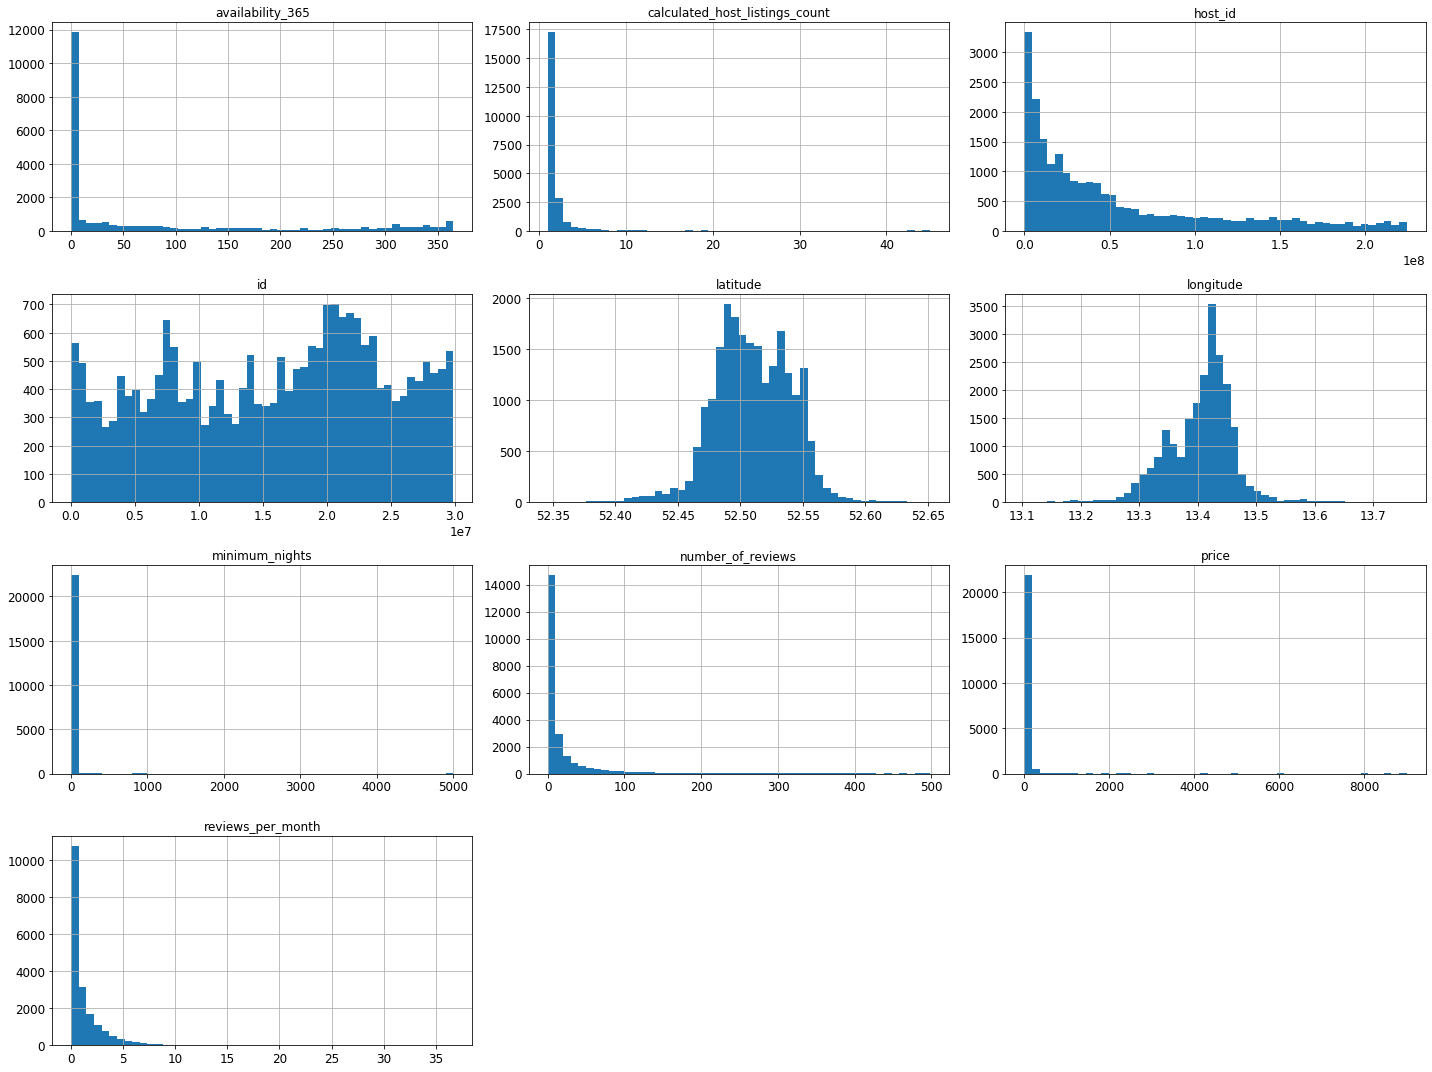

In [14]:
%matplotlib inline

bnb.hist(bins=50, figsize=(20,15))
save_fig("attribute_histogram_plots")
plt.show()

## Data Visualization

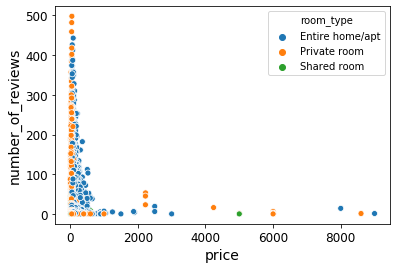

In [15]:
sns.scatterplot(x = 'price',y = 'number_of_reviews', data =bnb,hue = 'room_type')

In [16]:
bnb.isnull().sum()

id                                   0
name                                59
host_id                              0
host_name                           26
neighbourhood_group                  0
neighbourhood                        0
latitude                             0
longitude                            0
room_type                            0
price                                0
minimum_nights                       0
number_of_reviews                    0
last_review                       3908
reviews_per_month                 3914
calculated_host_listings_count       0
availability_365                     0
dtype: int64

# Discover and visualize the data to gain insights

Saving figure bad_visualization_plot


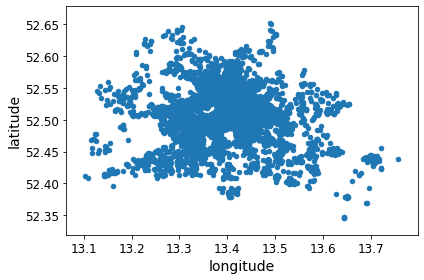

In [17]:
bnb.plot(kind="scatter", x="longitude", y="latitude")
save_fig("bad_visualization_plot")

Saving figure better_visualization_plot


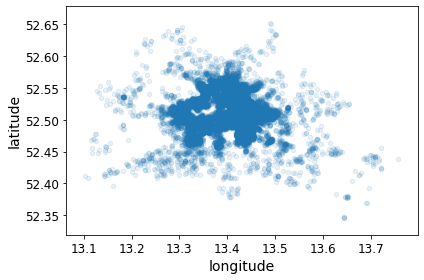

In [18]:
bnb.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)
save_fig("better_visualization_plot")

In [19]:
bnb.describe()
bnb.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2015,Berlin-Mitte Value! Quiet courtyard/very central,2217,Ian,Mitte,Brunnenstr. Süd,52.534537,13.402557,Entire home/apt,60,4,118,2018-10-28,3.76,4,141
1,2695,Prenzlauer Berg close to Mauerpark,2986,Michael,Pankow,Prenzlauer Berg Nordwest,52.548513,13.404553,Private room,17,2,6,2018-10-01,1.42,1,0
2,3176,Fabulous Flat in great Location,3718,Britta,Pankow,Prenzlauer Berg Südwest,52.534996,13.417579,Entire home/apt,90,62,143,2017-03-20,1.25,1,220
3,3309,BerlinSpot Schöneberg near KaDeWe,4108,Jana,Tempelhof - Schöneberg,Schöneberg-Nord,52.498855,13.349065,Private room,26,5,25,2018-08-16,0.39,1,297
4,7071,BrightRoom with sunny greenview!,17391,Bright,Pankow,Helmholtzplatz,52.543157,13.415091,Private room,42,2,197,2018-11-04,1.75,1,26


Saving figure housing_prices_scatterplot


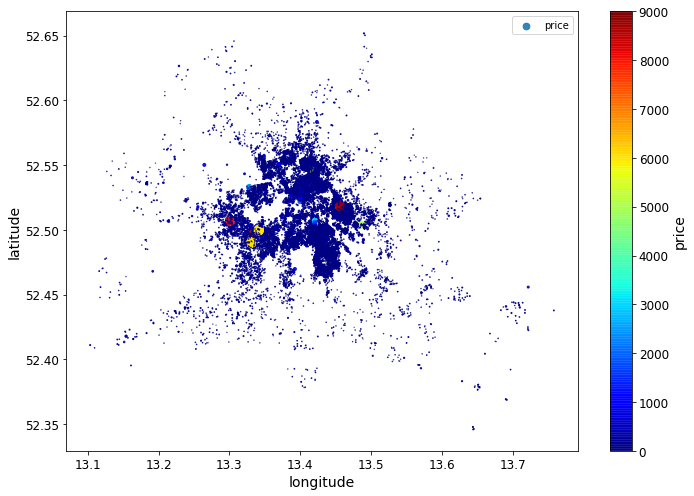

In [20]:
bnb.plot(kind="scatter", x="longitude", y="latitude", alpha=0.9,
    s=bnb["price"]/100, label="price", figsize=(10,7),
    c="price", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)
plt.legend()
save_fig("housing_prices_scatterplot")

Saving figure california_housing_prices_plot


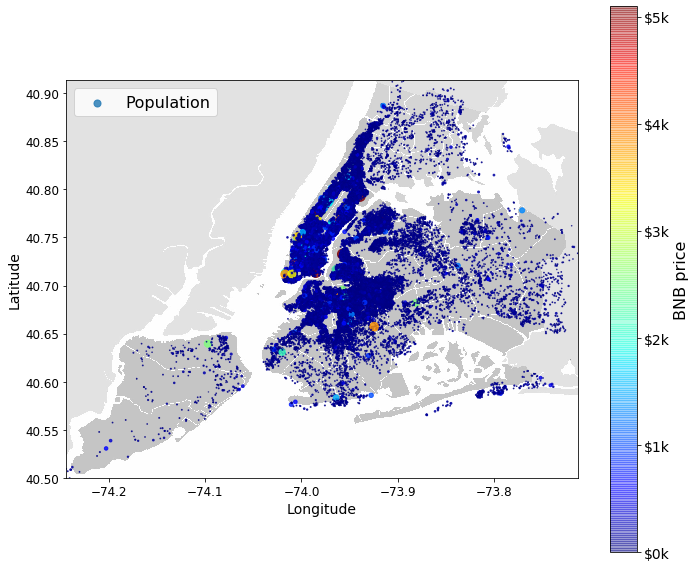

In [18]:
NY_img=mpimg.imread(PROJECT_ROOT_DIR + r'/datasets/new-york-city-airbnb-open-data/New_York_City_.png',0)
ax = bnb.plot(kind="scatter", x="longitude", y="latitude", figsize=(10,8),
                       s=bnb['price']/100, label="Population",
                       c="price", cmap=plt.get_cmap("jet"),
                       colorbar=False, alpha=0.8,sharex=False
                      )

plt.imshow(NY_img,  alpha=0.4,extent=[bnb["longitude"].min(), bnb["longitude"].max(), bnb["latitude"].min(), bnb["latitude"].max()],
           cmap=plt.get_cmap("jet"))
#plt.imshow(NY_img,  alpha=0.4,extent=[-74.258, -73.7, 40.49,40.92],
#           cmap=plt.get_cmap("jet"))
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

prices = bnb["price"]
tick_values = np.linspace(prices.min(), prices.max(), 11)
cbar = plt.colorbar()
cbar.ax.set_yticklabels(["$%dk"%(round(v/1000)) for v in tick_values], fontsize=14)
cbar.set_label('BNB price', fontsize=16)

plt.legend(fontsize=16)
save_fig("california_housing_prices_plot")
plt.show()

Saving figure scatter_matrix_plot


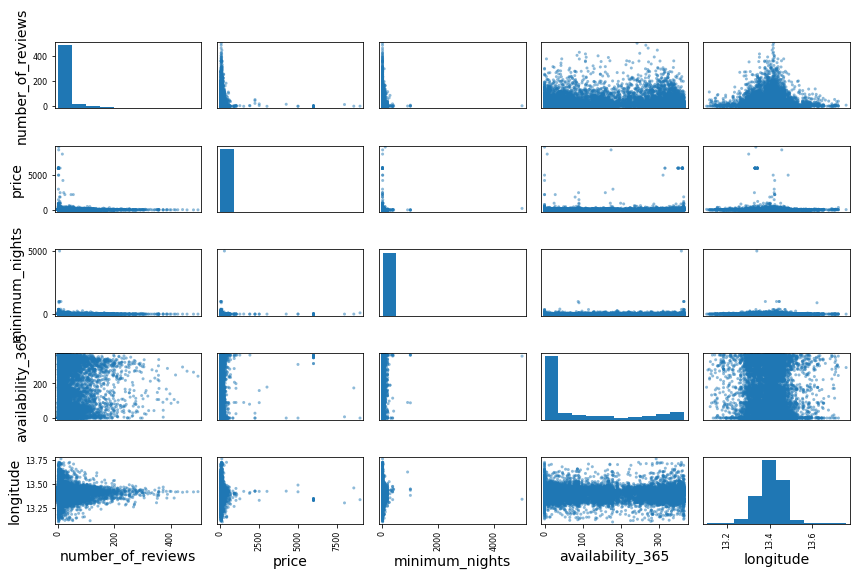

In [21]:


attributes = ["number_of_reviews", "price", "minimum_nights",
              "availability_365","longitude"]
scatter_matrix(bnb[attributes], figsize=(12, 8))
save_fig("scatter_matrix_plot")

# Prepare the data for Machine Learning algorithms

We drop last review.

In [22]:
bnb =  bnb.drop('last_review', axis =1)

In [23]:
bnb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22552 entries, 0 to 22551
Data columns (total 15 columns):
id                                22552 non-null int64
name                              22493 non-null object
host_id                           22552 non-null int64
host_name                         22526 non-null object
neighbourhood_group               22552 non-null object
neighbourhood                     22552 non-null object
latitude                          22552 non-null float64
longitude                         22552 non-null float64
room_type                         22552 non-null object
price                             22552 non-null int64
minimum_nights                    22552 non-null int64
number_of_reviews                 22552 non-null int64
reviews_per_month                 18638 non-null float64
calculated_host_listings_count    22552 non-null int64
availability_365                  22552 non-null int64
dtypes: float64(3), int64(7), object(5)
memory usage: 2

We assume that if reviews per month is na then that implies that the properties has never been reviewed. This is infered from the fact that the number of na values for number_of_reviews matches the the number of na values for last_review.

In [24]:
bnb['reviews_per_month'] = bnb['reviews_per_month'].fillna(value=0)

Finally the remaining na values are for host_id and name. We will replace the na values of both with the most requent value of their respective feature. 

In [25]:
bnb.isnull().sum()

id                                 0
name                              59
host_id                            0
host_name                         26
neighbourhood_group                0
neighbourhood                      0
latitude                           0
longitude                          0
room_type                          0
price                              0
minimum_nights                     0
number_of_reviews                  0
reviews_per_month                  0
calculated_host_listings_count     0
availability_365                   0
dtype: int64

In [27]:
bnb['name'].describe()

count              22493
unique             21873
top       Berlin Wohnung
freq                  14
Name: name, dtype: object

In [28]:
bnb['name'] = bnb['name'].fillna('Berlin Wohnungl')

In [29]:
bnb['host_name'].describe()


count     22526
unique     5997
top        Anna
freq        216
Name: host_name, dtype: object

In [30]:
bnb['host_name'] = bnb['host_name'].fillna('Anna')

In [31]:
bnb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22552 entries, 0 to 22551
Data columns (total 15 columns):
id                                22552 non-null int64
name                              22552 non-null object
host_id                           22552 non-null int64
host_name                         22552 non-null object
neighbourhood_group               22552 non-null object
neighbourhood                     22552 non-null object
latitude                          22552 non-null float64
longitude                         22552 non-null float64
room_type                         22552 non-null object
price                             22552 non-null int64
minimum_nights                    22552 non-null int64
number_of_reviews                 22552 non-null int64
reviews_per_month                 22552 non-null float64
calculated_host_listings_count    22552 non-null int64
availability_365                  22552 non-null int64
dtypes: float64(3), int64(7), object(5)
memory usage: 2

In [32]:
bnb_ce = bnb.copy()

encoder = ce.BinaryEncoder(cols=['name','host_name','neighbourhood_group','neighbourhood','room_type'])
df_binary = encoder.fit_transform(bnb_ce)

df_binary.head()
df = df_binary

In [33]:
bnb.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,2015,Berlin-Mitte Value! Quiet courtyard/very central,2217,Ian,Mitte,Brunnenstr. Süd,52.534537,13.402557,Entire home/apt,60,4,118,3.76,4,141
1,2695,Prenzlauer Berg close to Mauerpark,2986,Michael,Pankow,Prenzlauer Berg Nordwest,52.548513,13.404553,Private room,17,2,6,1.42,1,0
2,3176,Fabulous Flat in great Location,3718,Britta,Pankow,Prenzlauer Berg Südwest,52.534996,13.417579,Entire home/apt,90,62,143,1.25,1,220
3,3309,BerlinSpot Schöneberg near KaDeWe,4108,Jana,Tempelhof - Schöneberg,Schöneberg-Nord,52.498855,13.349065,Private room,26,5,25,0.39,1,297
4,7071,BrightRoom with sunny greenview!,17391,Bright,Pankow,Helmholtzplatz,52.543157,13.415091,Private room,42,2,197,1.75,1,26


# Select and train a model 

In [34]:
X_train, X_test, Y_train, Y_test = train_test_split(
    df.loc[:, df.columns != 'price'], 
    df['price'], test_size = 0.2, random_state=0)
# let us divide this into train and test data


In [35]:
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(18041, 56)
(4511, 56)
(18041,)
(4511,)


## Scaling 

In [36]:
#This is a crucial step in rescaling input data so that all the features are mean zero with a unit variance. 
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
#print(X_train)

## Linear Regression

In [37]:

lin_reg = LinearRegression()
lin_reg.fit(X_train, Y_train)
Y_pred = lin_reg.predict(X_train)
lin_mse = mean_squared_error(Y_train, Y_pred)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

192.1361293223858

In [38]:
bnb['price'].describe()

count    22552.000000
mean        67.143668
std        220.266210
min          0.000000
25%         30.000000
50%         45.000000
75%         70.000000
max       9000.000000
Name: price, dtype: float64

In [39]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

scores = cross_val_score(lin_reg, df.loc[:, df.columns != 'price'], df['price'],
                         scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-scores)
display_scores(lin_rmse_scores)

Scores: [ 88.85252151  75.87225614 221.98974386  70.8935175  122.879193
  67.55088955 180.70932131 132.86499067 562.75656792 201.34463104]
Mean: 172.5713632492371
Standard deviation: 140.48272185152038


## Decision Tree

In [40]:
from sklearn.metrics import mean_squared_error

#classifier = DecisionTreeClassifier(criterion = 'gini',random_state = 0)
tree_reg = DecisionTreeRegressor(criterion = 'mse',random_state = 0)
tree_reg.fit(X_train, Y_train)
Y_pred = tree_reg.predict(X_train)
tree_mse = mean_squared_error(Y_pred, Y_train)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

In [41]:
scores = cross_val_score(tree_reg, df.loc[:, df.columns != 'price'], df['price'],
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [42]:
display_scores(tree_rmse_scores)

Scores: [398.82339583 222.84594092 224.25445834  77.25366114 137.09380316
 262.770992   176.52177871 162.56120389 557.23911836 343.2747731 ]
Mean: 256.263912545517
Standard deviation: 134.92556070330363


## Random Forest

In [43]:
forest_reg = RandomForestRegressor(n_estimators=10, random_state=42)
forest_reg.fit(X_train, Y_train)
Y_pred = forest_reg.predict(X_train)
forest_mse = mean_squared_error(Y_pred, Y_train)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

45.05042322163369

In [44]:
forest_scores = cross_val_score(forest_reg, df.loc[:, df.columns != 'price'], df['price'],
                         scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [117.87370033  68.92816412 215.93426302  63.56842925 120.78681399
 118.49853341 186.38651816 134.91112688 559.33812868 343.55280605]
Mean: 192.97784838837418
Standard deviation: 144.69600146282525


# Fine-tune your model

In [ ]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [ ]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

In [ ]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

**Note**: we specify `n_estimators=10` to avoid a warning about the fact that the default value is going to change to 100 in Scikit-Learn 0.22.

In [ ]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=10, random_state=42)
forest_reg.fit(housing_prepared, housing_labels)

In [ ]:
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

In [ ]:
from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

In [ ]:
scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
pd.Series(np.sqrt(-scores)).describe()

In [ ]:
from sklearn.svm import SVR

svm_reg = SVR(kernel="linear")
svm_reg.fit(housing_prepared, housing_labels)
housing_predictions = svm_reg.predict(housing_prepared)
svm_mse = mean_squared_error(housing_labels, housing_predictions)
svm_rmse = np.sqrt(svm_mse)
svm_rmse

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

The best hyperparameter combination found:

In [ ]:
grid_search.best_params_

In [ ]:
grid_search.best_estimator_

Let's look at the score of each hyperparameter combination tested during the grid search:

In [ ]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

In [ ]:
pd.DataFrame(grid_search.cv_results_)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),
    }

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(housing_prepared, housing_labels)

In [ ]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

In [ ]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

In [ ]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
#cat_encoder = cat_pipeline.named_steps["cat_encoder"] # old solution
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

In [ ]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [ ]:
final_rmse

We can compute a 95% confidence interval for the test RMSE:

In [ ]:
from scipy import stats

In [ ]:
confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
mean = squared_errors.mean()
m = len(squared_errors)

np.sqrt(stats.t.interval(confidence, m - 1,
                         loc=np.mean(squared_errors),
                         scale=stats.sem(squared_errors)))

We could compute the interval manually like this:

In [ ]:
tscore = stats.t.ppf((1 + confidence) / 2, df=m - 1)
tmargin = tscore * squared_errors.std(ddof=1) / np.sqrt(m)
np.sqrt(mean - tmargin), np.sqrt(mean + tmargin)

Alternatively, we could use a z-scores rather than t-scores:

In [ ]:
zscore = stats.norm.ppf((1 + confidence) / 2)
zmargin = zscore * squared_errors.std(ddof=1) / np.sqrt(m)
np.sqrt(mean - zmargin), np.sqrt(mean + zmargin)